In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
from scipy import stats
from  sklearn import linear_model as LM
import sklearn.metrics
from IPython.display import display, HTML

from mpl_toolkits import mplot3d#
import matplotlib.patches as mpatches
%matplotlib inline
#%matplotlib notebook  
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
url_database = "https://bitbucket.org/portierf/shared_files/downloads/invest.txt"
invest_data=pd.read_csv(url_database,sep=' ')

### Ex: 1

In [3]:
invest_data.head()

,year,gnp,invest,cpi,interest
0,1968,873.4,133.3,82.54,5.16
1,1969,944.0,149.3,86.79,5.87
2,1970,992.7,144.2,91.45,5.95
3,1971,1077.6,166.4,96.01,4.88
4,1972,1185.9,195.0,100.00,4.50


### Ex: 2

<AxesSubplot:xlabel='gnp', ylabel='invest'>

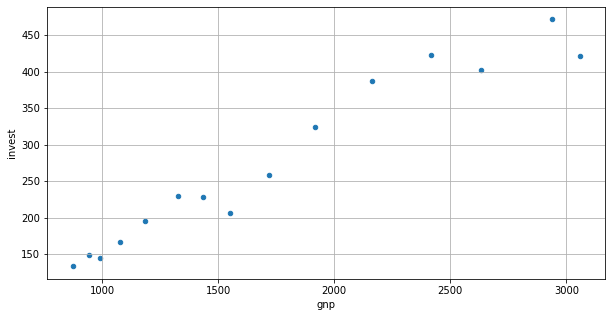

In [4]:
invest_data[["gnp", "invest"]].plot.scatter(x="gnp", y="invest",grid=True)

In [5]:
invest_data[["gnp", "invest"]] = np.log(invest_data[["gnp", "invest"]])

In [6]:
invest_data.head()

,year,gnp,invest,cpi,interest
0,1968,6.772394,4.892602,82.54,5.16
1,1969,6.850126,5.005958,86.79,5.87
2,1970,6.900429,4.971201,91.45,5.95
3,1971,6.982492,5.114395,96.01,4.88
4,1972,7.078257,5.273000,100.00,4.50


### Ex: 3

In [7]:
X = invest_data["gnp"].values
Y = invest_data["invest"].values

In [8]:
def X_to_Z(X):
    if np.ndim(X) == 0:
        X = np.array([X])       
    if np.ndim(X) == 1:
        X = X.reshape(-1,1)
    Z = np.ones((X.shape[0],1))

    #print(f"{ Z.shape =}")
    #print(f"{ X.shape =}")
    Z = np.append(Z,X, axis=1)
    return Z

In [9]:
def reg_param(X,Y):
    Z = X_to_Z(X)
    return LA.inv(Z.T @ Z) @ Z.T @ Y  

In [10]:
theta = reg_param(X, Y)

In [11]:
def predict(X, theta):
    Z = X_to_Z(X)
    return np.sum(Z * theta, axis=1)

In [12]:
def R2(X, Y, theta):
    Y_mean = np.mean(Y)
    Y_pred = predict(X, theta)  
    return LA.norm(Y_pred - Y_mean)**2 / LA.norm(Y - Y_mean)**2

_R2 = R2(X,Y,theta)

In [13]:
def noise_var(X, Y, theta):
    Z = X_to_Z(X) 
    Y_pred = predict(X, theta)   
    var = (LA.norm(Y - Y_pred)**2)/ (X.shape[0] - LA.matrix_rank(Z))

    return var   

In [14]:
def theta_std(X, Y, theta):
    n_var = noise_var(X, Y, theta)
    Z = X_to_Z(X)  
    return np.sqrt(n_var * np.diag(LA.inv(Z.T @ Z)))   

var_theta = theta_std(X, Y, theta)

In [15]:
print(f"{'intersect [theta 0]' : <25}{theta[0] : >20}")
print(f"{'la pente [theta 1]' : <25}{theta[1] : >20}")
print(f"{'écart-type du intersect' : <25}{var_theta[0] : >20}")
print(f"{'écart-type de la pente' : <25}{var_theta[1] : >20}")
print(f"{'R2' : <25}{_R2 : >20}")

intersect [theta 0]       -1.9635913352307508
la pente [theta 1]          1.015281401598935
écart-type du intersect   0.40954727166233656
écart-type de la pente   0.055383060354856656
R2                         0.9627572956059072


### Ex: 4


In [16]:
def gramm_mat_nsd(Z):
    return Z.T @ Z 

def t_test_theta(X, Y, theta):
    n = X.shape[0]
    Gramm_inv =  LA.inv(1/X.shape[0] * gramm_mat_nsd(X_to_Z(X)))
    n_var = noise_var(X, Y, theta)
    t_stat = np.sqrt(n) * theta / np.sqrt(n_var * np.diag(Gramm_inv))
    return t_stat

__t_test = t_test_theta(X, Y, theta)
t_test =__t_test[1]

In [17]:
def get_quantille(alpha):
    degre_de_liberte = 15 -2
    niveau_conf = 1 - alpha/2
    quantile_droite = stats.t.ppf(niveau_conf,df=degre_de_liberte)
    quantile_gauche = - quantile_droite
    return quantile_gauche, quantile_droite

In [18]:
quantile_gauche, quantile_droite = get_quantille(0.1)

In [19]:
degre_de_liberte = X.shape[0] - 2
p_value = 2 * (1 - stats.t.cdf(t_test,df=degre_de_liberte))
# trés petite valeur

In [20]:
print(f"{'valeur du test de student    ' : <25}{t_test : >25}")
print(f"{'quantile de gauche [avec 90%]' : <25}{quantile_gauche : >25}")
print(f"{'quantile de droite [avec 90%]' : <25}{quantile_droite : >25}")
print(f"{'p-valeur                     ' : <25}{p_value : >25}")
print("")
print("L'hypthése H0 (pente nulle) est à rejeter car la valeur du test est dans la zone de rejet"
       "(largement supérieur au quantile de droite) de plus la p-valeur est trés proche de 0.\n"
       "Donc, on conclu que la pente estimée est significative.")

valeur du test de student           18.331984456866714
quantile de gauche [avec 90%]      -1.7709333959867988
quantile de droite [avec 90%]       1.7709333959867988
p-valeur                        1.1363709973011282e-10

L'hypthése H0 (pente nulle) est à rejeter car la valeur du test est dans la zone de rejet(largement supérieur au quantile de droite) de plus la p-valeur est trés proche de 0.
Donc, on conclu que la pente estimée est significative.


### Ex: 5

In [21]:
x_invest_gnp_1000 = np.log(1000)
invest_gnp_1000 =  theta[0] + theta[1] * x_invest_gnp_1000

In [22]:
def get_intervals(x,X,Y,theta,alpha):
    z = X_to_Z(x)   
    Z = X_to_Z(X)
    quantile_gauche, quantile_droite = get_quantille(alpha)
   
    inv_gramm = LA.inv(gramm_mat_nsd(Z)) 
    noise_sig = np.sqrt(noise_var(X, Y, theta))

    r_value = np.diag(z @ inv_gramm @ z.T)
    ci_delta = quantile_droite * noise_sig * np.sqrt(r_value)
    pi_delta = quantile_droite * noise_sig * np.sqrt(1 + r_value)
    
    #y_pred = theta[0] + theta[1] * x  
    y_pred = z @ theta

    ci_inf = y_pred - ci_delta
    ci_sup = y_pred + ci_delta

    pi_inf = y_pred - pi_delta
    pi_sup = y_pred + pi_delta
    
    return  (ci_inf, ci_sup, pi_inf, pi_sup)
    
intervals_gnp_1000 = get_intervals(x_invest_gnp_1000,X,Y,theta,0.1)

In [23]:
print("invest = %f si GNP = 1000" %invest_gnp_1000)
print("L'intervalle de confiance pour la valeur prédite pour gnp = 1000 [90%%]: [%f, %f]"
      %(intervals_gnp_1000[0],intervals_gnp_1000[1]))
print("L'intervalle de confiance pour la variabel à expliquer [90%%]: [%f, %f]"
       %(intervals_gnp_1000[2],intervals_gnp_1000[3]))


invest = 5.049724 si GNP = 1000
L'intervalle de confiance pour la valeur prédite pour gnp = 1000 [90%]: [4.988223, 5.111225]
L'intervalle de confiance pour la variabel à expliquer [90%]: [4.882820, 5.216628]


### Ex: 6

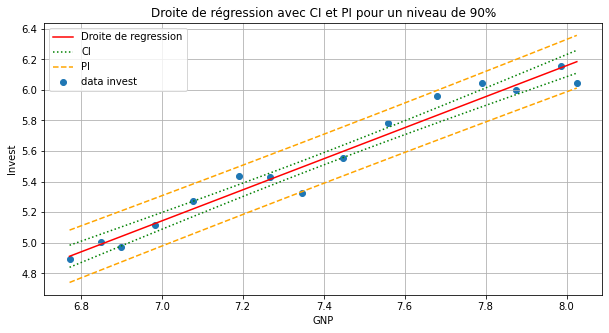

In [24]:
plt.grid()


plt.scatter(X, Y, label='data invest')
plt.xlabel('GNP')
plt.ylabel('Invest')

X_range = np.linspace(X.min(), X.max())

intervals = get_intervals(X_range,X,Y,theta,0.1)

plt.plot(X_range, theta[0] + theta[1] * X_range, c='r', label='Droite de regression')

plt.plot(X_range, intervals[0], ls=':', c='g', label='CI')
plt.plot(X_range, intervals[1], ls=':', c='g')
plt.plot(X_range, intervals[2], ls='--', c='orange', label='PI')
plt.plot(X_range, intervals[3], ls='--', c='orange')


# Legende, nom des axes et titre
plt.title('Droite de régression avec CI et PI pour un niveau de 90%')
plt.legend()
plt.show()

### Ex: 7

In [25]:
def linear_reg_sk(X, Y):
    lr = LM.LinearRegression()
    lr.fit(X.reshape(-1, 1), Y.reshape(-1, 1))
    return np.array([lr.intercept_[0], lr.coef_[0][0]])

In [26]:
def r2_sk(Y, Y_pred):
    return sklearn.metrics.r2_score(Y, Y_pred, multioutput='uniform_average')

In [27]:
theta_sk  = linear_reg_sk(X, Y)
theta_sk  = linear_reg_sk(X, Y)
invest_gnp_100 =  theta_sk[0] + theta_sk[1] * np.log(1000)
_R2_sk = r2_sk(Y,predict(X,theta_sk))

In [28]:
print("coefficients de régression avec sklearn:")
print(f"{'    theta_0' : <15}{theta_sk[0] : >10}")
print(f"{'    theta_1' : <15}{theta_sk[1] : >10}")
print("coefficient de determination R2 avec sklearn: %f" %_R2_sk)
print("invest = %f si GNP = 1000" %invest_gnp_100)

print("")
print(f"les valeurs calculées avec sklearn coïncident parfaitement" 
      f"avec celles des questions précédentes. { np.isclose(theta, theta_sk) = }")

coefficients de régression avec sklearn:
    theta_0    -1.9635913352301815
    theta_1    1.015281401598871
coefficient de determination R2 avec sklearn: 0.962757
invest = 5.049724 si GNP = 1000

les valeurs calculées avec sklearn coïncident parfaitementavec celles des questions précédentes.  np.isclose(theta, theta_sk) = array([ True,  True])


### Ex: 8

<AxesSubplot:xlabel='gnp', ylabel='invest'>

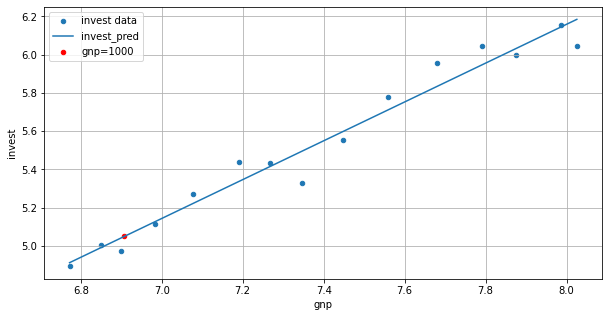

In [29]:
invest_data["invest_pred"] = pd.Series(predict(X,theta_sk))
f1 = invest_data.plot.scatter(x="gnp", y="invest", label="invest data")
f2 = invest_data.plot(ax=f1, x="gnp", y="invest_pred")

gnp_1000_df = pd.DataFrame(data = {'gnp':np.log(1000),
                                   'invest':predict(np.log(1000),theta_sk)
                               })

gnp_1000_df.plot.scatter(ax=f2, 
                      c='red', 
                      x='gnp', 
                      y='invest', 
                      label='gnp=1000', grid=True)

### Ex: 9

In [30]:
X2 = invest_data[["gnp","interest"]].values

In [31]:
G_nsd = gramm_mat_nsd(X_to_Z(X2))
rg_G_nsd = LA.matrix_rank(G_nsd)

In [32]:
print("la matrice de Gramm non standardisée:")
print("")
print(G_nsd)
print("")
print("le rang de la matrice de Gramm non standardisée est de %d. Donc elle est de rang plein" %rg_G_nsd)

la matrice de Gramm non standardisée:

[[ 15.         110.75282116 111.79      ]
 [110.75282116 820.24847688 839.18854302]
 [111.79       839.18854302 943.8557    ]]

le rang de la matrice de Gramm non standardisée est de 3. Donc elle est de rang plein


### Ex: 10

In [33]:
theta_m = reg_param(X2, Y)
std_theta_m = theta_std(X2, Y, theta_m)
r2_m = R2(X2,Y,theta_m)

In [34]:
__t_test_m = t_test_theta(X2, Y, theta_m)
degre_de_liberte = X.shape[0] - 3
p_value_m = 2 * (1 - stats.t.cdf(np.abs(__t_test_m),df=degre_de_liberte))

In [35]:
print(f"{'theta_0' : <25}{theta_m[0] : >20}")
print(f"{'theta_1' : <25}{theta_m[1] : >20}")
print(f"{'theta_2' : <25}{theta_m[2] : >20}")
print("")

print(f"{'écart-type de theta_0' : <25}{std_theta_m[0] : >20}")
print(f"{'écart-type de theta_1' : <25}{std_theta_m[1] : >20}")
print(f"{'écart-type de theta_2' : <25}{std_theta_m[2] : >20}")
print("")

print(f"{'coeff de determination R²' : <25}{r2_m : >20}")
print("")

print("Les valeurs du test de student pour :")
print(f"{'    theta_0' : <15}{__t_test_m[0] : >10}")
print(f"{'    theta_1' : <15}{__t_test_m[1] : >10}")
print(f"{'    theta_2' : <15}{__t_test_m[2] : >10}")
print("")

print("Les p-valeurs pour :")
print(f"{'    theta_0' : <15}{p_value_m[0] : >10}")
print(f"{'    theta_1' : <15}{p_value_m[1] : >10}")
print(f"{'    theta_2' : <15}{p_value_m[2] : >10}")
print("")
print("L'hypothèse H0 est à rejeter pour theta_0 et theta_1, on peut voir que les 2 p-valeurs qui leurs correspondent sont très proches de 0\n"
      "et donc une très forte présomption contre l'hypothèse null H0.\n"
      "Par contre pour le theta_2, on une p-valeur très grande ce qui veut qu'on retient l'hypothèse H0 pour theta_0 qui correspond à 'Interest'\n"
       "Conclusion : theta_0 et theta_1 --> significatifs   theta_2 --> NON significatif.")

theta_0                   -2.1804547259108333
theta_1                    1.0512426913197779
theta_2                  -0.0065288794060883865

écart-type de theta_0      0.6623991977963286
écart-type de theta_1     0.10206137806191681
écart-type de theta_2    0.015344205065603566

coeff de determination R²  0.9633108306726423

Les valeurs du test de student pour :
    theta_0    -3.2917532707842954
    theta_1    10.300102852639208
    theta_2    -0.4254947961249635

Les p-valeurs pour :
    theta_0    0.0064383670509406965
    theta_1    2.5995168484449493e-07
    theta_2    0.6780071418829157

L'hypothèse H0 est à rejeter pour theta_0 et theta_1, on peut voir que les 2 p-valeurs qui leurs correspondent sont très proches de 0
et donc une très forte présomption contre l'hypothèse null H0.
Par contre pour le theta_2, on une p-valeur très grande ce qui veut qu'on retient l'hypothèse H0 pour theta_0 qui correspond à 'Interest'
Conclusion : theta_0 et theta_1 --> significatifs   theta_2 --> 

### Ex: 11

In [36]:
x_invest_gnp_1000_10 = np.array([[np.log(1000), 10]])
invest_gnp_1000_10 =predict(x_invest_gnp_1000_10,theta_m)
intervals_gnp_1000_10 = get_intervals(x_invest_gnp_1000_10,X2,Y,theta_m,0.01)

In [37]:
print("invest = %f si GNP = 1000 et interest = 10" %invest_gnp_1000_10)
print("L'intervalle de confiance pour la valeur prédite pour gnp = 1000 [99%%]: [%f, %f]"
      %(intervals_gnp_1000_10[0],intervals_gnp_1000_10[1]))
print("L'intervalle de confiance pour la variabel à expliquer [99%%]: [%f, %f]"
       %(intervals_gnp_1000_10[2],intervals_gnp_1000_10[3]))

invest = 5.015984 si GNP = 1000 et interest = 10
L'intervalle de confiance pour la valeur prédite pour gnp = 1000 [99%]: [4.753810, 5.278158]
L'intervalle de confiance pour la variabel à expliquer [99%]: [4.637736, 5.394232]


### Ex: 12

Text(0.5, 0, 'invest')

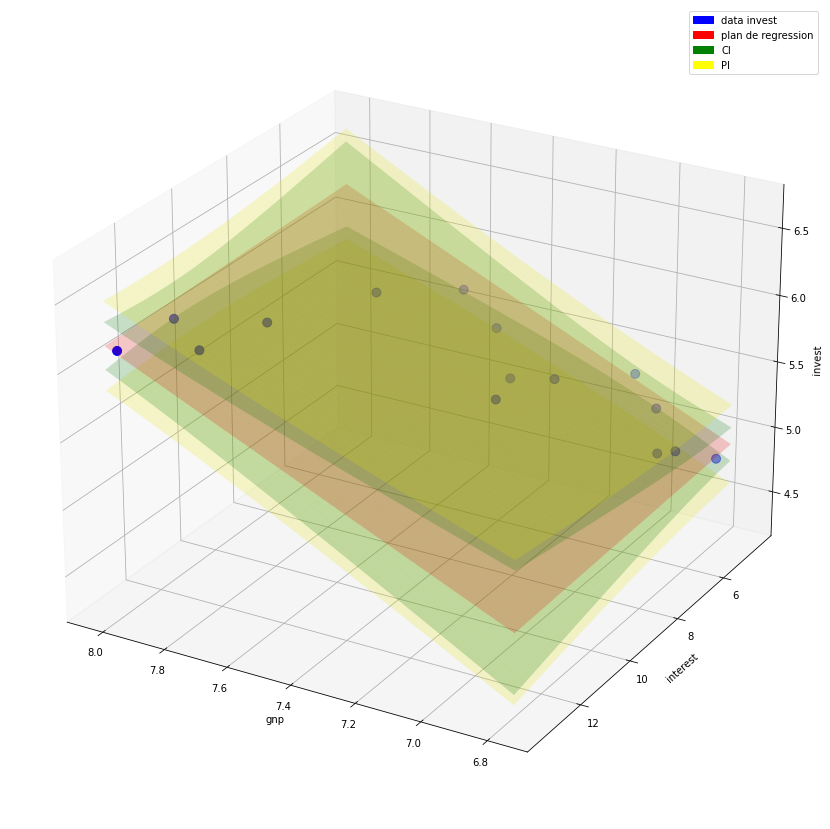

In [38]:
_X = invest_data["gnp"].values
_Y = invest_data["interest"].values
_Z = invest_data["invest"].values

X_range = np.linspace(_X.min(), _X.max())
Y_range = np.linspace(_Y.min(), _Y.max())

__X, __Y = np.meshgrid(X_range, Y_range)
X2_grid = np.concatenate((__X.reshape(-1,1), __Y.reshape(-1,1)), axis=1)
Z2_grid = X_to_Z(X2_grid)

__Z = (Z2_grid @ theta_m).reshape(50,50)

intervals = get_intervals(X2_grid, X2, Y, theta_m, 0.01)

__intervals  = [ interval.reshape(50,50) for interval in intervals ]

fig = plt.figure(figsize=plt.figaspect(1)*3)
ax = plt.axes(projection='3d')

ax.plot_surface(__X, __Y, __Z, rstride=1, cstride=1, alpha = 0.2, color='red')
ax.scatter(_X, _Y, _Z, s=80, c='blue', label="data invest")

ax.plot_surface(__X, __Y, __intervals[0], alpha=0.2, color='green')
ax.plot_surface(__X, __Y, __intervals[1], alpha=0.2, color='green')
ax.plot_surface(__X, __Y, __intervals[2], alpha=0.2, color='yellow')
ax.plot_surface(__X, __Y, __intervals[3], alpha=0.2, color='yellow')

patches = [
            mpatches.Patch(color='blue', label='data invest'),
            mpatches.Patch(color='red', label='plan de regression'),
            mpatches.Patch(color='green', label='CI'),
            mpatches.Patch(color='yellow', label='PI')
           ]

plt.legend(handles=patches)

ax.view_init(25, 120)
ax.set_xlabel('gnp')
ax.set_ylabel('interest')
ax.set_zlabel('invest')



### Ex: 13

In [39]:
def multi_linear_reg_sk(X2, Z):
    lr = LM.LinearRegression()
    lr.fit(X2,Z)
    return np.array([lr.intercept_, lr.coef_[0], lr.coef_[1]])

In [40]:
theta_m_sk = multi_linear_reg_sk(X2,_Z)
invest_gnp_1000_10_sk =  theta_m_sk[0] + theta_m_sk[1] * np.log(1000) + theta_m_sk[2] * 10
_R2_m_sk = r2_sk(_Z,predict(X2,theta_m_sk))

In [41]:
print("coefficients de régression avec sklearn:")
print(f"{'    theta_0' : <15}{theta_m_sk[0] : >10}")
print(f"{'    theta_1' : <15}{theta_m_sk[1] : >10}")
print(f"{'    theta_2' : <15}{theta_m_sk[2] : >10}")
print("coefficient de determination R2 avec sklearn: %f" %_R2_sk)
print("invest = %f si GNP = 1000 et interest = 10" %invest_gnp_1000_10_sk)

print("")
print(f"les valeurs calculées avec sklearn coïncident parfaitement" 
      f"avec celles des questions précédentes. { np.isclose(theta_m, theta_m_sk) = }")
print("")
print(f"le R2 calculées avec sklearn coïncide parfaitement" 
      f"avec cellui des questions précédentes. { np.isclose(_R2_m_sk, r2_m) = }")
print("")
print(f"la prédiction de de gnp=1000, invest=10 calculées avec sklearn coïncide" 
      f"avec celle des questions précédentes." 
      f"{ np.isclose(invest_gnp_1000_10, invest_gnp_1000_10_sk) = }")

coefficients de régression avec sklearn:
    theta_0    -2.180454725911402
    theta_1    1.0512426913196597
    theta_2    -0.006528879406068252
coefficient de determination R2 avec sklearn: 0.962757
invest = 5.015984 si GNP = 1000 et interest = 10

les valeurs calculées avec sklearn coïncident parfaitementavec celles des questions précédentes.  np.isclose(theta_m, theta_m_sk) = array([ True,  True,  True])

le R2 calculées avec sklearn coïncide parfaitementavec cellui des questions précédentes.  np.isclose(_R2_m_sk, r2_m) = True

la prédiction de de gnp=1000, invest=10 calculées avec sklearn coïncideavec celle des questions précédentes. np.isclose(invest_gnp_1000_10, invest_gnp_1000_10_sk) = array([ True])
